In [1]:
import numpy as np
import pandas as pd
# import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2

# from datetime import datetime
from catboost import CatBoostRegressor

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train  = pd.read_csv('../csv/train.csv')
test = pd.read_csv('../csv/test.csv')

In [3]:
print('Строк в обучающем датасете:', train.shape[0])
print('Строк в тестовом датасете:', test.shape[0])

Строк в обучающем датасете: 10000
Строк в тестовом датасете: 5000


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [5]:
train.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


Заменяем Id и DistrictId на строковый тип данных, чтобы они не мешали при проведении корреляционного анализа

In [6]:
train['Id'] = train['Id'].astype(str)
train['DistrictId'] = train['DistrictId'].astype(str)

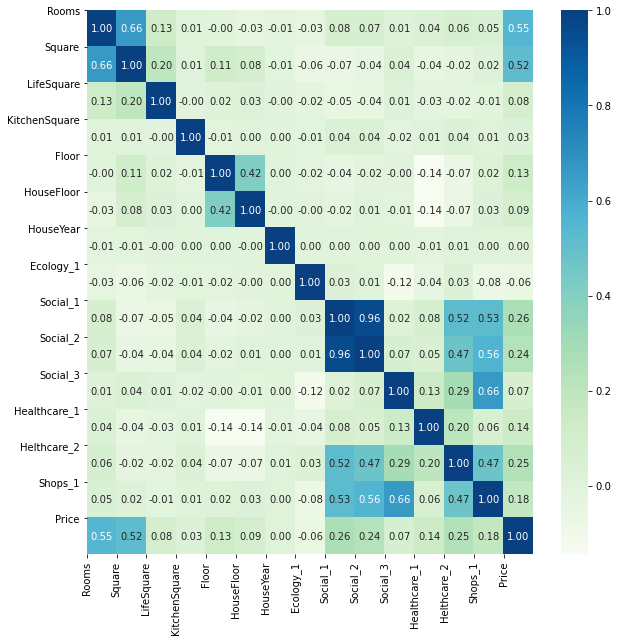

In [7]:
corr = train.corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, cmap='GnBu', annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

Как видно из матрицы выше, наиболее сильную корреляцию с целевой переменной имеют количество комнат (Rooms), а также величина общей площади (Square)

In [8]:
train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Для определения наличия выбросов построим гистограммы по имеющимся фичам в датасете

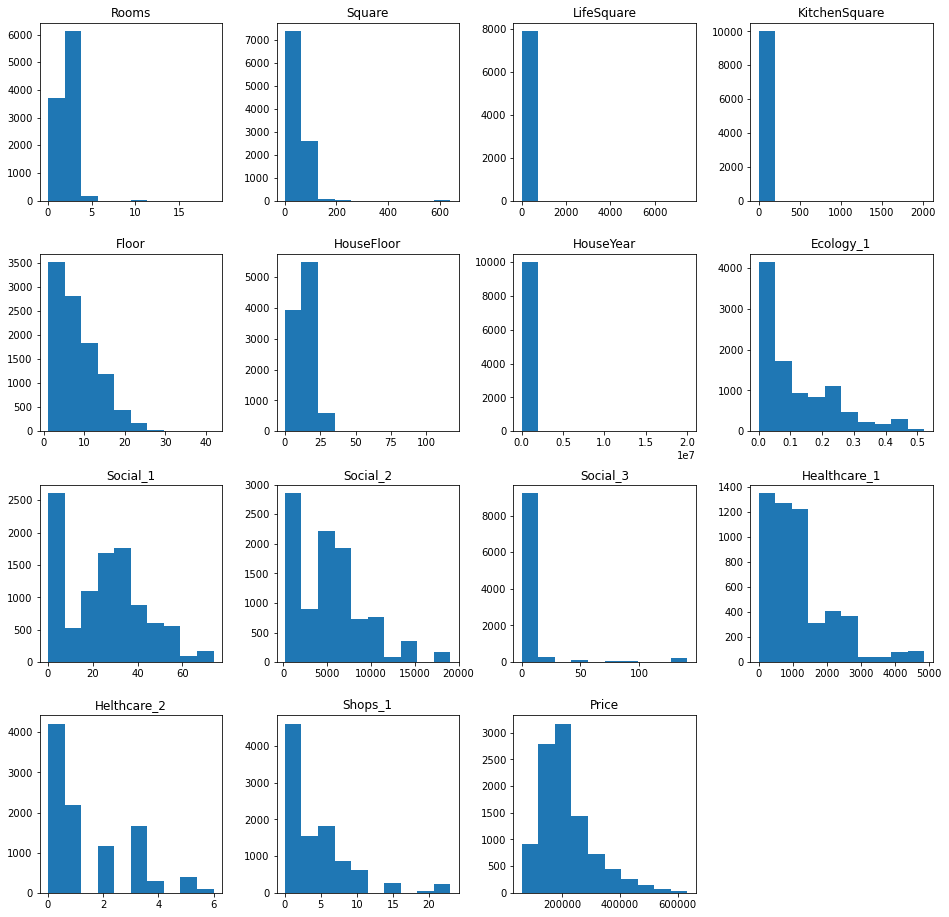

In [9]:
train.hist(figsize=(16,16), grid=False)
plt.show()

Выбросы наблюдаются в HouseFloor, HouseYear, KitchenSquare, LifeSquare, Social_3, Square

## Работа с выбросами

Пропуски заполним средними значениями:

In [10]:
train.loc[train['Healthcare_1'].isna(), 'Healthcare_1'] = train['Healthcare_1'].mean()

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   10000 non-null  float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [11]:
train.nlargest(10, 'HouseFloor')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8854,78,30,2.0,65.773749,66.811789,1.0,8,117.0,1977,0.000078,B,B,22,6398,141,1046.00000,3,23,B,207248.370520
6131,10806,5,1.0,51.944587,48.709601,1.0,6,99.0,1977,0.150818,B,B,16,3433,4,2643.00000,4,5,B,296127.115515
8599,9300,74,2.0,71.747869,74.579809,9.0,5,99.0,1977,0.075779,B,B,6,1437,3,1142.90446,0,2,B,243329.912579
2781,1674,76,2.0,74.344672,41.044132,5.0,42,48.0,2016,0.000000,B,B,7,1660,39,1786.00000,1,5,B,411691.504766
7728,7453,24,3.0,126.621358,62.455481,12.0,22,48.0,2011,0.111627,B,B,50,12238,8,1970.00000,2,3,B,179396.521035
3974,6502,20,1.0,126.389517,103.637322,14.0,22,47.0,2012,0.019509,B,B,37,7687,11,176.00000,5,5,B,450706.552655
540,5279,93,2.0,60.804544,30.923827,11.0,5,45.0,2016,0.050900,B,B,43,10621,1,30.00000,2,3,B,213171.135199
4323,6589,30,1.0,62.110823,52.812128,4.0,31,44.0,2009,0.000078,B,B,22,6398,141,1046.00000,3,23,B,117647.461002
359,15722,31,2.0,82.435495,48.655394,16.0,23,40.0,2013,0.151346,B,A,32,5889,10,830.00000,4,1,B,558262.139114
3330,3298,31,1.0,57.551691,21.551876,10.0,32,40.0,1977,0.151346,B,A,32,5889,10,830.00000,4,1,B,393799.531732


In [12]:
train.nlargest(10, 'Floor')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2781,1674,76,2.0,74.344672,41.044132,5.0,42,48.0,2016,0.000000,B,B,7,1660,39,1786.00000,1,5,B,411691.504766
6755,8296,146,1.0,86.386754,71.904999,0.0,37,38.0,2012,0.236108,B,B,16,3893,27,1142.90446,3,10,B,269113.584248
8357,8016,31,1.0,59.519896,24.050533,10.0,33,40.0,1977,0.151346,B,A,32,5889,10,830.00000,4,1,B,389554.063540
339,11563,8,1.0,50.390862,41.642898,0.0,32,32.0,2008,0.092291,B,B,21,4346,2,165.00000,1,2,B,97480.845791
3330,3298,31,1.0,57.551691,21.551876,10.0,32,40.0,1977,0.151346,B,A,32,5889,10,830.00000,4,1,B,393799.531732
4323,6589,30,1.0,62.110823,52.812128,4.0,31,44.0,2009,0.000078,B,B,22,6398,141,1046.00000,3,23,B,117647.461002
561,11692,113,2.0,70.566571,70.694221,12.0,28,30.0,2014,0.050756,B,B,24,5469,1,145.00000,0,1,B,333862.631152
2597,4320,29,1.0,47.235843,21.629796,12.0,28,30.0,2015,0.069660,B,B,31,6119,4,1142.90446,1,2,B,115651.359306
9613,7657,38,1.0,4.502784,4.618547,1.0,28,1.0,1977,0.060753,B,B,15,2787,2,520.00000,0,7,B,483283.488083
2308,1471,23,2.0,62.348477,NaN,1.0,27,25.0,1977,0.075779,B,B,6,1437,3,1142.90446,0,2,B,168381.124180


Значение этажности дома более 48 приравниваем к выбросам и заменяем средним значением

In [13]:
train.loc[(train['HouseFloor'] > 48), 'HouseFloor'] = train['HouseFloor'].mean()
train.nlargest(10, 'HouseFloor')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2781,1674,76,2.0,74.344672,41.044132,5.0,42,48.0,2016,0.000000,B,B,7,1660,39,1786.0,1,5,B,411691.504766
7728,7453,24,3.0,126.621358,62.455481,12.0,22,48.0,2011,0.111627,B,B,50,12238,8,1970.0,2,3,B,179396.521035
3974,6502,20,1.0,126.389517,103.637322,14.0,22,47.0,2012,0.019509,B,B,37,7687,11,176.0,5,5,B,450706.552655
540,5279,93,2.0,60.804544,30.923827,11.0,5,45.0,2016,0.050900,B,B,43,10621,1,30.0,2,3,B,213171.135199
4323,6589,30,1.0,62.110823,52.812128,4.0,31,44.0,2009,0.000078,B,B,22,6398,141,1046.0,3,23,B,117647.461002
359,15722,31,2.0,82.435495,48.655394,16.0,23,40.0,2013,0.151346,B,A,32,5889,10,830.0,4,1,B,558262.139114
3330,3298,31,1.0,57.551691,21.551876,10.0,32,40.0,1977,0.151346,B,A,32,5889,10,830.0,4,1,B,393799.531732
5494,300,31,2.0,106.427686,34.230415,32.0,4,40.0,2013,0.151346,B,A,32,5889,10,830.0,4,1,B,624549.354546
5653,8500,31,1.0,80.606246,25.299592,29.0,6,40.0,2014,0.151346,B,A,32,5889,10,830.0,4,1,B,460492.010947
8340,15270,31,2.0,81.042938,46.633001,16.0,15,40.0,1977,0.151346,B,A,32,5889,10,830.0,4,1,B,547586.080087


In [14]:
train.nlargest(10, 'HouseYear')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.00000,3,6,B,254084.534396
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.00000,5,8,B,243028.603096
585,15051,53,2.0,59.597891,44.869530,10.0,3,24.0,2020,0.049637,B,B,34,7759,0,229.00000,1,3,B,243114.222804
707,4345,62,1.0,49.275155,1.377284,1.0,5,1.0,2020,0.072158,B,B,2,629,1,1142.90446,0,0,A,135353.885620
790,6845,169,3.0,87.371123,64.905206,12.0,4,24.0,2020,0.178917,B,B,18,3594,4,192.00000,1,5,B,295304.011974
918,2530,53,2.0,64.233072,47.405440,13.0,13,24.0,2020,0.049637,B,B,34,7759,0,229.00000,1,3,B,283334.496716
1499,6731,120,2.0,85.087643,77.976325,10.0,7,10.0,2020,0.341072,B,B,27,5664,48,2300.00000,3,11,B,536020.260344
2493,3445,53,1.0,35.672788,21.391266,8.0,4,24.0,2020,0.049637,B,B,34,7759,0,229.00000,1,3,B,170847.416766
2877,8832,1,3.0,83.260743,79.438325,1.0,15,21.0,2020,0.007122,B,B,1,264,0,1142.90446,0,1,B,242243.090839
3357,9600,62,1.0,55.911215,43.821379,10.0,6,17.0,2020,0.072158,B,B,2,629,1,1142.90446,0,0,A,138770.715048


In [15]:
train.loc[train['HouseYear'] == 20052011, 'HouseYear'] = 2011
train.loc[train['HouseYear'] == 4968, 'HouseYear'] = 1968

#### LifeSquare, KitchenSquare, Rooms, Square:

Определим средние значения LifeSquare в зависимости от количества комнат:

In [16]:
for room in train['Rooms'].value_counts().index:
    ls_mean = train.loc[train['Rooms'] == room, 'LifeSquare'].mean()
    print(f'{room:.0f} - {ls_mean:.2f}')

2 - 35.97
1 - 25.16
3 - 54.94
4 - 65.67
5 - 89.45
0 - 90.56
10 - 37.32
6 - 38.70
19 - 21.78


Исходя из вышеприведенных данных, количество жилых комнат > 5 - является выбросом, т.к. при этом площадь комнаты становится меньше 3 квадратных метров.

Жилая площадь менее 10 м2 также приравняем к выбросу и устанавим среднюю площадь в зависимости от кол-ва комнат

In [17]:
train.loc[(train['LifeSquare'] < 10) & (train['Rooms'] == 1), 'LifeSquare'] = 25.16
train.loc[(train['LifeSquare'] < 10) & (train['Rooms'] == 2), 'LifeSquare'] = 35.97
train.loc[(train['LifeSquare'] < 10) & (train['Rooms'] == 3), 'LifeSquare'] = 54.94
train.loc[(train['LifeSquare'] < 10) & (train['Rooms'] == 4), 'LifeSquare'] = 65.67
train.loc[(train['LifeSquare'] < 10) & (train['Rooms'] == 5), 'LifeSquare'] = 89.45

train = train.drop(index=[4853])

train.loc[train['Rooms'] == 10, 'Rooms'] = 2
train.loc[train['Rooms'] == 19, 'Rooms'] = 1
train.loc[train['Rooms'] == 6, 'Rooms'] = 2

In [18]:
for room in train['Rooms'].value_counts().index:
    ls_mean = train.loc[train['Rooms'] == room, 'LifeSquare'].mean()
    print(f'{room:.0f} - {ls_mean:.1f}')

2 - 36.8
1 - 25.9
3 - 55.8
4 - 67.0
5 - 89.4
0 - 113.0


In [19]:
train[train['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,1142.90446,0,0,B,268394.744389
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,1142.90446,0,1,B,302211.260887
2269,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,1142.90446,0,1,B,98129.976788
3911,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.00000,1,0,B,217009.338463
4366,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.00000,0,0,B,212864.799112
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,1142.90446,3,9,B,158998.110646
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,1142.90446,0,1,B,219281.918007


In [20]:
train.loc[train['Rooms'] == 0, 'Rooms'] = 1

Площадь кухни менее 5м2 приравнивается к 5, а для площади кухни более 20м2, а также в тех случаях, когда KitchenSquare превышает Square - установим медианное значение.

In [21]:
train.loc[(train['Rooms'] > 0) & (train['KitchenSquare'] < 5), 'KitchenSquare'] = 5
train.loc[train['KitchenSquare'] > 20, 'KitchenSquare'] = train['KitchenSquare'].median()
train.loc[(train['KitchenSquare'] > train['Square']), 'KitchenSquare'] = train['KitchenSquare'].median()

train['KitchenSquare'].value_counts()

5.0     4381
8.0     1306
6.0     1095
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
14.0      51
15.0      31
16.0      16
20.0      14
17.0      12
19.0      11
18.0       6
Name: KitchenSquare, dtype: int64

Общая площадь менее 20м2 заменяется на медиану:

In [22]:
train.loc[train['Square'] < 20, 'Square'] = train['Square'].median()

In [23]:
train.nsmallest(10, 'Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3084,3732,112,1.0,20.213128,13.800281,5.0,5,9.0,1974,0.069660,B,B,31,6119,4,1142.90446,1,2,B,113050.229914
6054,6351,111,1.0,20.606762,14.740084,5.0,4,15.0,1975,0.135650,B,B,46,7960,6,350.00000,3,11,B,108379.889782
4118,828,90,1.0,20.924926,10.651455,5.0,7,5.0,1968,0.265089,B,B,37,5288,0,1937.00000,3,2,B,128808.087357
7694,10476,90,1.0,21.121279,15.202620,5.0,4,5.0,1964,0.265089,B,B,37,5288,0,1937.00000,3,2,B,113846.123763
9642,16202,105,1.0,22.072457,16.540036,5.0,4,9.0,1963,0.069660,B,B,31,6119,4,1142.90446,1,2,B,126778.794309
6993,14642,90,1.0,22.682706,14.664334,5.0,5,5.0,1969,0.265089,B,B,37,5288,0,1937.00000,3,2,B,118004.829969
4364,9905,41,1.0,22.691542,13.499648,5.0,7,9.0,1972,0.175055,B,B,36,10055,3,1142.90446,1,0,B,136682.956950
8598,1098,101,1.0,23.015919,15.739110,5.0,3,5.0,1967,0.225825,A,B,41,6558,7,1548.00000,3,2,B,132427.987621
1476,1775,101,1.0,23.583220,18.442768,5.0,3,5.0,1968,0.225825,A,B,41,6558,7,1548.00000,3,2,B,108232.647619
9033,2915,29,1.0,23.891837,13.949307,5.0,5,9.0,1974,0.069660,B,B,31,6119,4,1142.90446,1,2,B,124258.914679


3 квартиры площадью более 300м2 удалим.

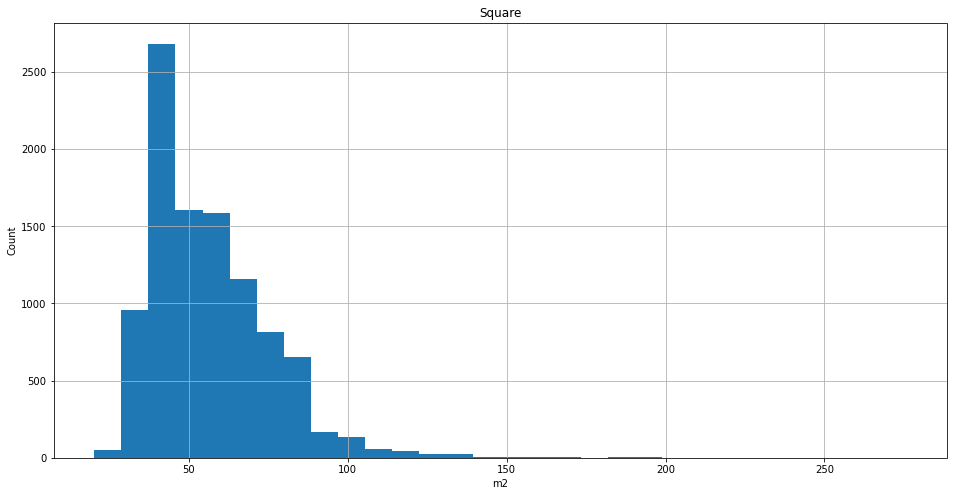

In [24]:
train = train.drop(train[train.Square > 300].index)

plt.figure(figsize = (16, 8))

train['Square'].hist(bins=30)

plt.ylabel('Count')
plt.xlabel('m2')

plt.title('Square')
plt.show()

3 наибольших значения жилой площади являются выбросом. Заменяем на разность общей площади и площади кухни

In [25]:
train.loc[train['LifeSquare'] > 250, 'LifeSquare'] = train['Square'] - train['KitchenSquare']
train.loc[train.loc[:,'Id'] == '16550'][:]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4328,16550,27,3.0,81.694417,76.694417,5.0,9,17.0,2016,0.017647,B,B,2,469,0,1142.90446,0,0,B,217357.492366


Пропуски LifeSquare заменяются разностью Square и KitchenSquare.

In [26]:
train['LifeSquare'].isna().sum()

2112

In [27]:
train.loc[train['LifeSquare'].isna(), 'LifeSquare'] = train['Square'] - train['KitchenSquare']

train['LifeSquare'].isna().sum()

0

In [28]:
train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000
mean,1.887655,56.257762,40.645986,7.018407,8.525910,12.582616,1984.861345,0.118863,24.689376,5352.658063,8.027611,1143.069297,1.319228,4.229692,214170.694247
std,0.811550,19.031598,19.117727,2.387365,5.239519,6.581600,18.409819,0.119032,17.534628,4007.262320,23.799261,736.783881,1.493636,4.803415,92874.630207
min,1.000000,20.213128,10.523868,5.000000,1.000000,0.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.810536,26.512559,5.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153907.528147
50%,2.000000,52.513850,36.063721,6.000000,7.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,1142.904460,1.000000,3.000000,192304.063740
75%,2.000000,65.890819,49.150944,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1142.904460,2.000000,6.000000,249177.966254
max,5.000000,275.645284,233.949309,20.000000,42.000000,48.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [29]:
target = 'Price'

In [30]:
X = train.drop(columns=target)
# X_1 = pd.read_csv('../csv/train.csv')
# X_1 = X_1.drop(columns=target)
y = train[target]
# y_1 = pd.read_csv('../csv/train.csv')
# y_1 = y_1[target]

In [31]:
X = pd.get_dummies(X)

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### Обучение модели

In [33]:
cboost_model = CatBoostRegressor(
    iterations=100,
    depth=6,
    eval_metric='R2',
    silent=True
)

In [34]:
%%time
cboost_model.fit(X_train, y_train)

CPU times: user 5.77 s, sys: 259 ms, total: 6.03 s
Wall time: 2.25 s


In [35]:
y_train_preds = cboost_model.predict(X_train)
y_test_preds = cboost_model.predict(X_valid)

In [36]:
cboost_model.best_score_

{'learn': {'R2': 0.81565192089141, 'RMSE': 40062.86012660911}}

In [37]:
r2(y_train, y_train_preds)

0.8156519208537034

In [38]:
test_id = test["Id"].copy()

pred_df = pd.DataFrame()
pred_df["Id"] = test_id
pred_df["Price"] = pd.Series(y_test_preds)

pred_df.to_csv("./TAbaydulin_predictions.csv", index=False)